# Hallo

In [ ]:
from datageneration.generatecrystaldata import fill_volume_fcc
from datageneration.disordercrystaldata import add_gaussian_noise
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

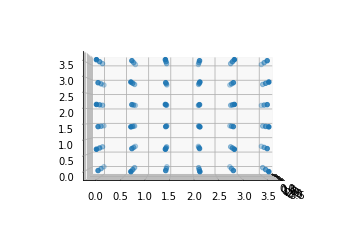

In [62]:
fcc_data=fill_volume_fcc(4,4,4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data[:,0],fcc_data[:,1],fcc_data[:,2])
ax.view_init(0,0)

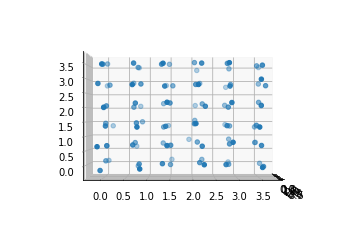

In [63]:
fcc_data_noise=add_gaussian_noise(fcc_data,0.07,0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data_noise[:,0],fcc_data_noise[:,1],fcc_data_noise[:,2])
ax.view_init(0,0)

In [64]:
from mixedcrystalsignature import MixedCrystalSignature
mcs=MixedCrystalSignature()
mcs.set_datapoints(fcc_data)
mcs.set_inner_volume([[1,3],[1,3],[1,3]])
mcs.calc_signature()
mcs.signature

,N,ba0,ba1,ba2,ba3,ba4,ba5,ba6,ba7,q4,...,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,dist11
0,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
1,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
2,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
3,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
4,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
5,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
6,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
7,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
8,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
9,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0


In [65]:
mcs.set_datapoints(fcc_data_noise)
mcs.set_inner_volume([[0,4],[0,4],[0,4]])
mcs.calc_signature()
mcs.signature

,N,ba0,ba1,ba2,ba3,ba4,ba5,ba6,ba7,q4,...,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,dist11
0,10,2,0,2,12,11,0,16,2,0.556769,...,7,0,0,0,0,0,0,0,0,0
1,14,4,1,6,29,18,1,32,0,0.241014,...,14,16,4,5,7,16,16,5,4,4
2,15,4,1,8,32,21,2,37,0,0.239583,...,17,17,2,8,13,19,11,7,6,2
3,15,6,0,4,33,26,1,34,1,0.232852,...,16,17,5,4,11,22,11,5,11,3
4,13,6,0,2,28,14,1,27,0,0.202015,...,10,15,4,5,11,16,9,2,3,2
5,12,4,0,2,25,9,3,23,0,0.214885,...,10,9,5,6,6,13,12,2,2,0
6,14,6,0,2,30,20,1,32,0,0.194392,...,15,17,3,6,12,19,7,7,5,0
7,13,6,0,0,29,15,0,28,0,0.184832,...,9,12,7,6,8,8,18,5,1,4
8,13,3,2,6,26,12,1,28,0,0.209103,...,6,17,5,5,9,10,14,5,4,3
9,14,6,0,2,32,19,1,31,0,0.230962,...,13,16,4,6,6,21,11,4,10,0


In [66]:
import pickle
with open('./pretrained/standardscaler.pkl',mode='rb') as f:
    scaler=pickle.load(f)
with open('./pretrained/mlpclassifier.pkl',mode='rb') as f:
    classifier=pickle.load(f)

In [67]:
prediction=classifier.predict(scaler.transform(mcs.signature))
np.mean(prediction)

1.0

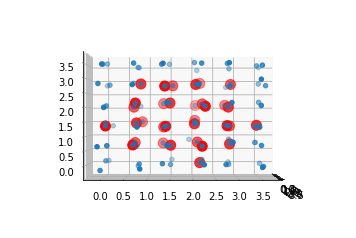

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data_noise[:,0],fcc_data_noise[:,1],fcc_data_noise[:,2])
solid_data=mcs.datapoints[mcs.solid_indices]
ax.scatter(solid_data[:,0],solid_data[:,1],solid_data[:,2],color='red',s=100)
ax.view_init(0,0)